# Week 7 - Recurrent Neural Networks (RNNs)

RNNs are a class of neural networks that allow previous outputs to be used as inputs while having hidden states. This allows data to be processed while taking into account the previous information. 

RNNs go through a process of backpropagation through time (BPTT) to update the weights. This is similar to backpropagation, but the weights are updated based on the previous time steps.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from livelossplot import PlotLosses

from sklearn.model_selection import train_test_split

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 1. RNNs using Pytorch

Like previous examples, we will use the MNIST dataset to demonstrate how to use RNNs in Pytorch.

In [3]:
from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

def plot_confusion_matrix(true_labels, pred_labels):
    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(true_labels, pred_labels)
    heatmap(cm, annot=True, ax=ax, cmap="Blues")
    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")
    ax.set_title("Confusion Matrix")
    plt.show()

def load_mnist_dataset():
    # Load the datadet from SkDataset
    X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
    y = y.astype(np.int64)

    # Scale values between [0, 1]
    X = X / 255.0
    return X, y

X, y = load_mnist_dataset()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Convert to torch tensors
X_train = torch.from_numpy(X_train.reshape(-1, 28, 28)).float().to(device)
y_train = torch.from_numpy(y_train).to(device)
X_test = torch.from_numpy(X_test.reshape(-1, 28, 28)).float().to(device)
y_test = torch.from_numpy(y_test).to(device)


In [6]:
# Build the model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.rnn = nn.RNN(input_size, hidden_size, 1, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)

        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [7]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

input_size = 28
sequence_length = 28
hidden_size = 128
num_classes = 10
epochs = 10


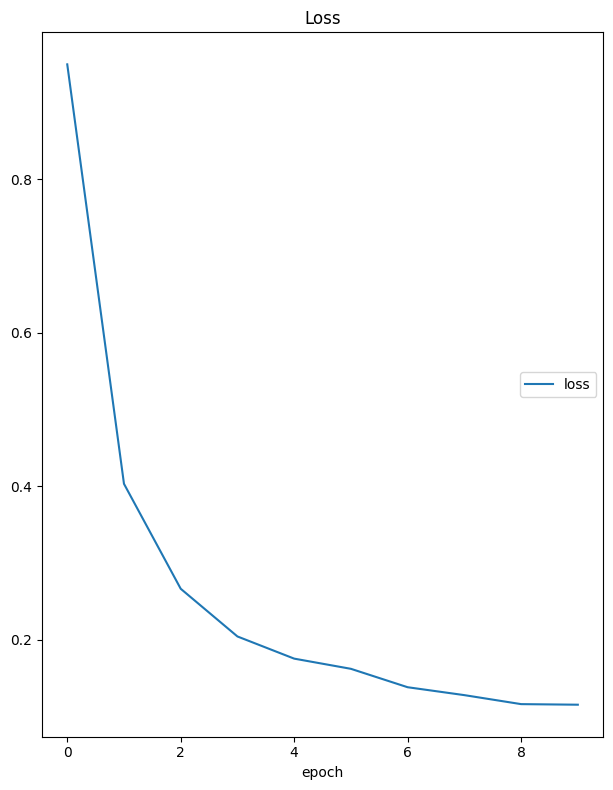

Loss
	loss             	 (min:    0.115, max:    0.950, cur:    0.115)


In [8]:
# Train the model
model = RNN(input_size, hidden_size, num_classes).to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

plotlosses = PlotLosses()

model.train()
for i in range(epochs):
    running_loss = 0.0
    for j, (images, labels) in enumerate(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)

        preds = model(images)
        loss = loss_function(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    plotlosses.update({"loss": epoch_loss})
    plotlosses.send()
    

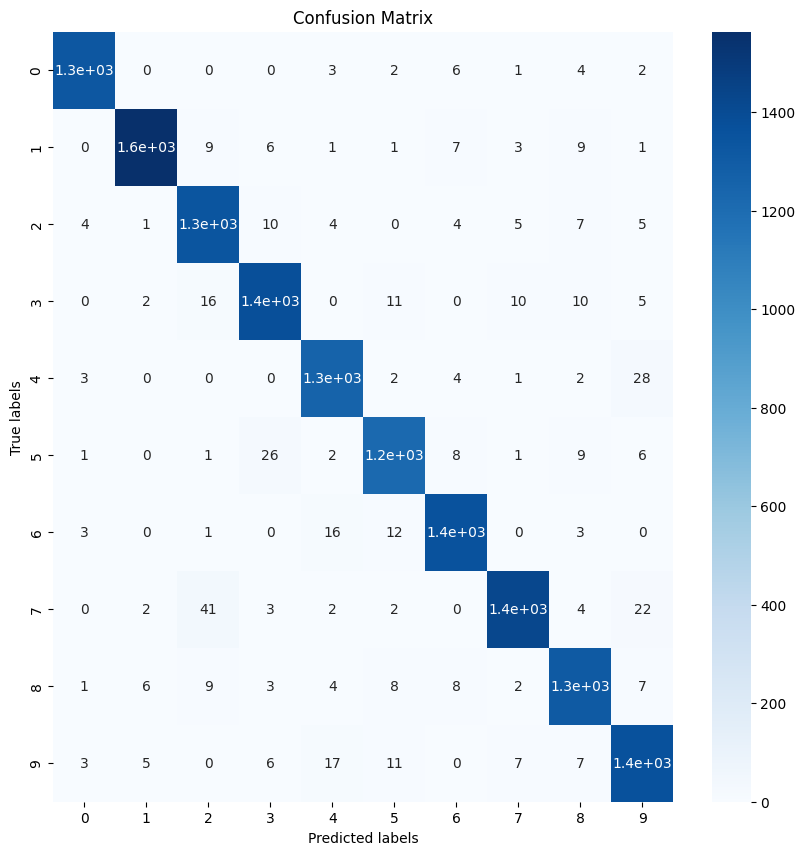

In [9]:
# Evaluate the model
# Use plot_confusion_matrix to plot the confusion matrix
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    y_pred = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        preds = model(images)
        _, predicted = torch.max(preds.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    plot_confusion_matrix(y_test.cpu().numpy(), y_pred)

## 2. LSTMs using Pytorch

The dataset we're going to use for this LSTM example is Stock Market prices. We will be using the CSV file located at `data/stocks.csv`, which is a copy of the `MSFT_2006-01-01_to_2018-01-01.csv` that can be found at [Kaggle](https://www.kaggle.com/datasets/szrlee/stock-time-series-20050101-to-20171231/data).

We're only going to focus on the Close price column of the dataset. The LSTM will look at a sequence of previous days to predict the next day's closing price.

In [3]:
df = pd.read_csv('data/stocks.csv', index_col="Date", parse_dates=True)

df.head(5)


,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,26.25,27.00,26.10,26.84,79974418,MSFT
2006-01-04,26.77,27.08,26.77,26.97,57975661,MSFT
2006-01-05,26.96,27.13,26.91,26.99,48247610,MSFT
2006-01-06,26.89,27.00,26.49,26.91,100969092,MSFT
2006-01-09,26.93,27.07,26.76,26.86,55627836,MSFT


In [4]:
# Get only the Close column

prices = df['Close'].values.reshape(-1, 1)

In [5]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
prices = scaler.fit_transform(prices)

In [6]:
# Create input sequences and corresponding outputs
# The inputs will be sequences of seq_length days of prices
# The output will be the price of the stock 1 day after the sequence
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [7]:
seq_length = 30
X, y = create_sequences(prices, seq_length)

# Split the data into training and testing sets
# Instead of randomly splitting the data into training and testing subsets
# we will take the first 80% of the data as training data and the last 20% as testing data
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

In [8]:
# Convert our data into tensors
X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)

X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)

print(f"{X_train.shape=} {X_test.shape=} {y_train.shape=} {y_test.shape=}")

X_train.shape=torch.Size([2390, 30, 1]) X_test.shape=torch.Size([598, 30, 1]) y_train.shape=torch.Size([2390, 1]) y_test.shape=torch.Size([598, 1])


In [9]:
# Create loaders
train_data = torch.utils.data.TensorDataset(X_train, y_train)
test_data = torch.utils.data.TensorDataset(X_test, y_test)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [10]:
# Build the Model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size


        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        h0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size).to(device)
        c0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size).to(device)

        out, _ = self.lstm(input_seq, (h0, c0))
        out = self.linear(out[:, -1, :])

        return out

In [11]:
input_size = 1
hidden_layer_size = 32
output_size = 1
epochs = 10

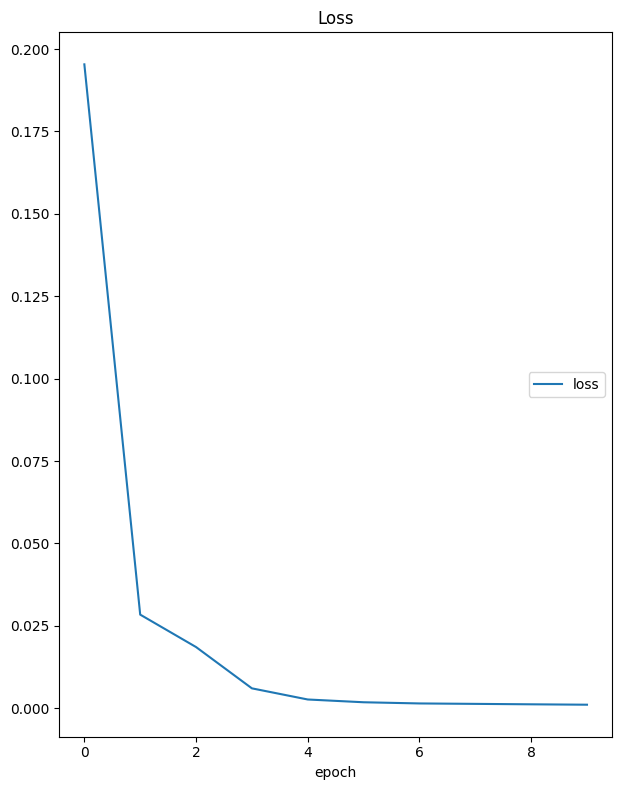

Loss
	loss             	 (min:    0.001, max:    0.195, cur:    0.001)


In [12]:
# Train the Model
model = LSTM(input_size, hidden_layer_size, output_size).to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

plotlosses = PlotLosses()

model.train()
for i in range(epochs):
    running_loss = 0.0
    for j, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        preds = model(inputs)

        loss = loss_function(preds, labels)

        optimizer.zero_grad()
        loss.backward()


        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    plotlosses.update({"loss": epoch_loss})
    plotlosses.send()

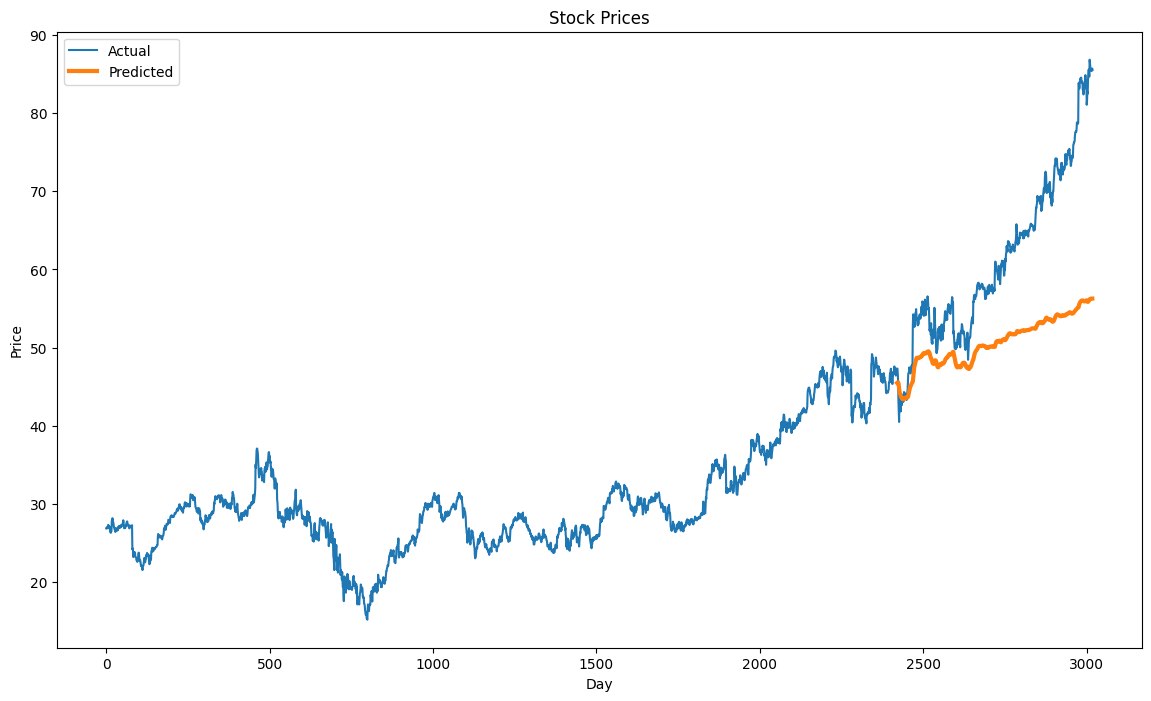

In [13]:
# Evaluate the Model
model.eval()
with torch.no_grad():
    preds = []
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        preds.extend(outputs.cpu().numpy())

        

    preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

    plt.figure(figsize=(14, 8))
    plt.plot(df.Close.values, label="Actual")
    plt.plot(np.arange(train_size + seq_length, train_size + seq_length + len(preds)), preds, linewidth=3, label="Predicted")
    plt.xlabel("Day")
    plt.ylabel("Price")
    plt.title("Stock Prices")
    plt.legend()
    plt.show()
    